## Contexte

Au vu des expérimentations précédentes, un CNN intégrant les connaissances acquises possédant une architecture plus adapté peut maintenant être implémenté.

Néanmoins les ressources système sur un serveur, bien que supérieures aux ressources locales, restent aussi limitées : il est donc nécessaire de reprendre le code afin que le CNN puisse être entrainé correctement.

## Objectif

Le nouveau CNN reprend les connaissances découlant des expérimentations et itérations précédentes.

Pour des raisons évidentes de puissance de calcul, l'architecture adoptée ne pourra néanmoins pas être équivalente à un CNN hyper-performant comme par exemple les CNN VGG16.

Un compromis est donc nécessaire : par conséquent, l'architecture du CNN sera aussi motivée par l'architecture des CNN LeNet composés des couches suivantes pour des photos d'entrée de dimension 32\*32\*1 :

* Convolution 1 : 30 filtres, dimension d'entrée (28, 28, 1), dimension du noyau (5, 5), fonction d'activation ReLU, pas de dépassement du noyau.

* Max-Pooling 1 : dimension du pooling (2, 2).

* Convolution 2 : 16 filtres, dimension du noyau (3, 3), fonction d'activation ReLU, Pas de dépassement du noyau.

* Max-Pooling 2 : dimension du pooling (2, 2).

* Dropout : Connexions coupées: 20%.

* Aplatissement

* Dense 1 : 128 neurones, fonction d'activation ReLU.

* Dense 2 : 10 neurones, fonction d'activation softmax.

Bien entendu les hyper-parmètres du CNN seront adaptés pour l'apprentissage sur des photos de taille 128*128.


## Préconisations

**Pour éviter de devoir ré-entrainer entièrement le CNN** : Les données de poids du CNN entrainé doivent se trouver dans le répertoire data du projet.

**Pour pouvoir afficher l'historique de l'entrainement du CNN** : Le fichier contenant les données d'historique doit se trouver dans le répertoire data du projet.

**Pour exécuter ce fichier sans entrainement du CNN**, par exemple à des fins d'affichage des historiques ou de préditions : le paramètre epochs devra être égal à zéro.


In [1]:
import os
import sys

# is_colab_platform = True
is_colab_platform = False

if(is_colab_platform == True):

    weights_path = racine + '/cnn_4_weights'
    history_path = racine + '/cnn_4_history'

else:

    sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

    from lib import ressources as res
    racine = os.path.abspath(os.path.realpath(res.dir_root))

    weights_path = racine + '/data/cnn_4_weights'
    history_path = racine + '/data/cnn_4_history'

    dataset_train = res.dir_dataset_train
    dataset_valid = res.dir_dataset_valid
    dataset_test = res.dir_dataset_test

os.listdir(dataset_train)


['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___healthy',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___healthy',
 'Potato___Late_blight',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___healthy',
 'Strawberry___Leaf_scorch',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___healthy',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spid

In [2]:
# les images vont être ajustées par le CNN de 256*256 à image_size*image_size
# normalement 128*128
image_size = 128

# nombre epochs a réaliser par itération
epochs = 0

## Gestion des sauvegardes liées au CNN et à son entrainement

In [3]:
from shutil import copyfile
import fnmatch
from datetime import datetime

# réalise une sauvegarde de secours des poids du cnn et de l'historique
def copy_weights_history_backup_files():
    # une sauvegarde de secours des poids du cnn et de l'historique est réalisée
    date_str = str(datetime.now()).replace(':', '-')

    for file in os.listdir(racine + os.sep + 'data'):
        if fnmatch.fnmatch(file, 'cnn_*'):
            # file est égal à file_path quand le fichier est dans le répertoire courant
            file_in_path = racine + os.sep + 'data' + os.sep + file
            file_out_path = racine + os.sep + 'data' + os.sep + 'save_' + file + '_' + date_str
            print(file_in_path)
            copyfile(file_in_path, file_out_path)


In [4]:
# des poids existent : le CNN a déjà été entrainé
is_trained = os.path.isfile(history_path) 

# les sauvegardes de secours sont réalisées
if (is_trained == True):
    copy_weights_history_backup_files()

C:\Users\NOEL\dev\python\DATA SCIENTIST\_projet\data\cnn_4_history
C:\Users\NOEL\dev\python\DATA SCIENTIST\_projet\data\cnn_4_weights.data-00000-of-00001
C:\Users\NOEL\dev\python\DATA SCIENTIST\_projet\data\cnn_4_weights.index


## Préparation du CNN et du jeu de données

In [5]:
# Import des librairies pour le CNN

# initialisation du CNN de manière séquentielle et non en graphe
from keras.models import Sequential

# les vidéos sont en 3D, on ajoute une dimension supplémentaire qui est le temps
# étape de convolution -> 2D car image
from keras.layers import Conv2D

# étape de max pooling
from keras.layers import MaxPooling2D

# étape de flatten
from keras.layers import Flatten

# couches du CNN
from keras.layers import Dense

# CNN optimization : Dropout added to avoid overfiting
from keras.layers import Dropout

In [6]:
# le cnn est créé
def create_cnn(is_weights=False, optimizer='adam'):

    # Le CNN est initialisé en mode séquentiel
    classifier = Sequential()

    # Conv2D -> couche de convolution
    classifier.add(Conv2D(filters = 64, kernel_size = (5, 5), strides = 1, input_shape = (image_size, image_size, 3), activation = 'relu'))

    # couche : Max pooling
    classifier.add(MaxPooling2D(pool_size = (2, 2)))

    # Conv2D -> couche de convolution
    classifier.add(Conv2D(filters = 128, kernel_size = (3, 3), strides = 1, activation = 'relu'))

    # couche : Max pooling
    classifier.add(MaxPooling2D(pool_size = (2, 2)))

    # Couche : Flattening
    classifier.add(Flatten())

    # Couche : Full connection
    classifier.add(Dense(units = 160, activation = 'relu'))

    classifier.add(Dropout(0.2))

    # Couche : Full connection
    classifier.add(Dense(units = 96, activation = 'relu'))

    classifier.add(Dropout(0.2))

    # Couche de sortie
    classifier.add(Dense(units = 38, activation = 'softmax'))

    # compilation du CNN
    classifier.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    # des poids existent : le CNN est initailisé avec ceux-ci
    if(is_weights == True):
        classifier.load_weights(weights_path)

    # le CNN est retourné
    return classifier

In [7]:
# augmentation du jeu d'images
from keras.preprocessing.image import ImageDataGenerator

# le jeu de données est enrichi de nouvelles images générées
def generate_images():

    # préparation du traitement de génération de nouvelles images pour le jeu d'entrainement
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.6,
                                   zoom_range = 0.6,
                                   horizontal_flip = True,
                                   vertical_flip=True,
                                   rotation_range=0.30)

    # préparation du traitement de génération de nouvelles images pour le jeu de test : l'échelle des valeurs est normalisées
    test_datagen = ImageDataGenerator(rescale = 1./255)

    # batch_size : 
    # 32 - 64 : suffit pour image
    # 64 - 128 : minimum pour texte
    # 32 - 64 : audio
    batch_size = 64

    # traitement des images du jeu d'entrainement
    # Le nom du répertoire est préfixé par '\\\\?\\' pour supporter les chemins de plus de 260 caractères
    training_set = train_datagen.flow_from_directory('\\\\?\\' + res.dir_dataset_train,
                                                 target_size = (image_size, image_size),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

    # traitement des images du jeu de test
    # Le nom du répertoire est préfixé par '\\\\?\\' pour supporter les chemins de plus de 260 caractères
    test_set = test_datagen.flow_from_directory('\\\\?\\' + res.dir_dataset_valid,
                                            target_size = (image_size, image_size),
                                            batch_size = batch_size,
                                            class_mode = 'categorical')

    # le jeux de données est retourné
    return training_set, test_set


In [8]:
# entrainement du CNN
def training_cnn(epochs = 0):

    steps_per_epoch = training_set.n // training_set.batch_size
    validation_step = test_set.n // test_set.batch_size


    # fit_generator -> entraine le CNN et effectue le test aussi et mesure la performance
    training_history = classifier.fit_generator(training_set,
                         steps_per_epoch = steps_per_epoch,
                         epochs = epochs,
                         validation_data = test_set,
                         validation_steps = validation_step)

    # l'historique de l'entrainement est retourné
    return training_history

In [9]:
def update_history(previous_history, training_history):
    
    train_accuracy = previous_history['accuracy'] + training_history['accuracy']
    val_accuracy = previous_history['val_accuracy'] + training_history['val_accuracy']
    train_loss = previous_history['loss'] + training_history['loss']
    val_loss = previous_history['val_loss'] + training_history['val_loss']

    history = {
        'accuracy': train_accuracy,
        'val_accuracy': val_accuracy,
        'loss': train_loss,
        'val_loss': val_loss
    }

    # retourne l'historique mis à jour
    return history

## Initialisation du CNN
## Génération des images supplémentaires du jeu de données
## Entrainement du CNN

In [10]:
import keras

# le learning rate est modifié
# optimizer = keras.optimizers.Adam(learning_rate=0.0001)
optimizer = keras.optimizers.Adam()

# le CNN est créé
classifier = create_cnn(is_weights = is_trained, optimizer=optimizer)
classifier.summary()

# des images supplémentaires pour le jeu de données sont générées
training_set, test_set = generate_images()

# le CNN est entrainé
training_history = training_cnn(epochs=epochs)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 115200)            0         
_________________________________________________________________
dense (Dense)                (None, 160)               18432160  
_________________________________________________________________
dropout (Dropout)            (None, 160)               0

## Enregistrement des poids du CNN entrainé 
## Enregistrement de l'historique des entrainements successifs

In [11]:
# enregistre l'historique de l'entrainement et les poids du CNN
import pickle

# l'history est mis à jour à partir de training_history et, le cas échéant, de l'historique 
# de l'entrainement précédent qui a été enregistré

# le CNN a déjà été entrainé, un historique d'entrainement existe déjà
if (is_trained == True):
    previous_history = pickle.load(open(history_path, 'rb'))
    # le CNN est plus entrainé
    if (epochs == 0):
        history = previous_history
    else:
        history = update_history(previous_history, training_history.history)
else:
    history = training_history.history

# history est enregistré
pickle.dump(history, open(history_path, 'wb'))

# les poids sont enregistrés
classifier.save_weights(weights_path);


In [12]:
# nombre d'epochs
print('epoch count -> ', len(history['accuracy']))

# l'historique mis à jour est affiché pour contrôle
# print(history)

epoch count ->  180


In [13]:
import pandas as pd

df_last_history = pd.DataFrame()

for key, value in history.items():
    df_last_history[key] = value[-10:]

# description mathématique des fonctions coûts et des scores du CNN : pour les 10 derniers entrainements
df_last_history.describe()

,accuracy,val_accuracy,loss,val_loss
count,10.000000,10.000000,10.000000,10.000000
mean,0.969210,0.976785,0.097222,0.075999
std,0.000552,0.003878,0.001248,0.018024
min,0.967906,0.969035,0.095008,0.059912
25%,0.968988,0.973954,0.096611,0.063844
50%,0.969323,0.978188,0.097574,0.068132
75%,0.969518,0.979699,0.098015,0.088180
max,0.969857,0.980953,0.098798,0.114242


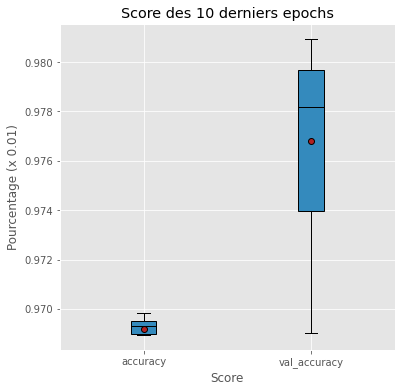

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

plt.figure(figsize=(6, 6))
plt.boxplot([df_last_history.accuracy, df_last_history.val_accuracy],
            labels=["accuracy", "val_accuracy"],
            showfliers=False, 
            medianprops=medianprops, 
            vert=True, 
            patch_artist=True, 
            showmeans=True, 
            meanprops=meanprops)

plt.title('Score des 10 derniers epochs')
plt.xlabel('Score')
plt.ylabel('Pourcentage (x 0.01)')
plt.show();


## Affichage de la fonction coût

In [15]:
# les scores obtenus pendant le (ou les) entrainement(s) sont lus
train_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

# les fonctions coûts pendant le (ou les) entrainement(s) sont lues
train_loss = history['loss']
val_loss = history['val_loss']

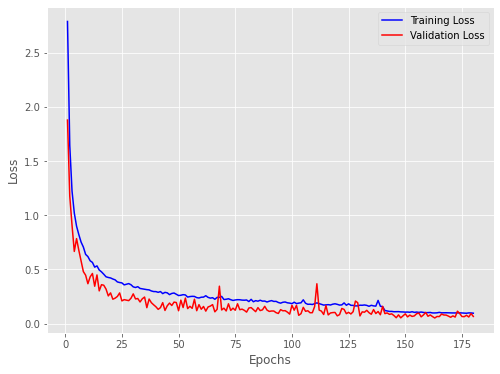

In [25]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
%matplotlib inline

plt.figure(figsize=(8, 6))

# Courbe de la perte sur l'échantillon d'entrainement
plt.plot(np.arange(1 , len(history['loss']) + 1, 1),
         train_loss,
         label = 'Training Loss',
         color = 'blue')

# Courbe de la perte sur l'échantillon de validation
plt.plot(np.arange(1 , len(history['val_loss']) + 1, 1),
         val_loss, 
         label = 'Validation Loss',
         color = 'red')

# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Affichage de la légende
plt.legend()

# Affichage de la figure
plt.show()

## Affichage de la performance du CNN

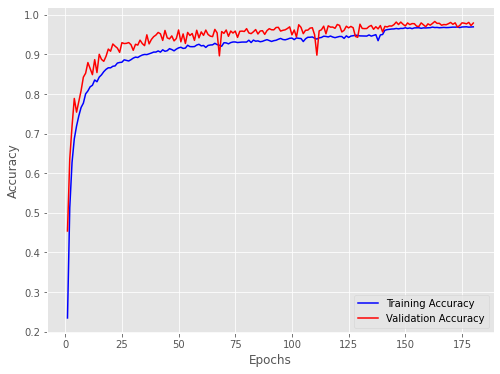

In [26]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt # Pour l'affichage d'images
from matplotlib import cm # Pour importer de nouvelles cartes de couleur
%matplotlib inline

plt.figure(figsize=(8, 6))

# Courbe de la précision sur l'échantillon d'entrainement
plt.plot(np.arange(1 , len(history['accuracy']) + 1, 1),
         train_accuracy,
         label = 'Training Accuracy',
         color = 'blue')

# Courbe de la précision sur l'échantillon de validation
plt.plot(np.arange(1 , len(history['val_accuracy']) + 1, 1),
         val_accuracy, 
         label = 'Validation Accuracy',
         color = 'red')

# Labels des axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Affichage de la légende
plt.legend()

# Affichage de la figure
plt.show()

## Test de prédiction
Première tentative

In [18]:
import numpy as np
from keras.preprocessing import image

# target_size = (128, 128) -> ce n'est pas la taille de l'image mais celle utilisée par le CNN -> voir intialisation CNN
# si la taille de l'image ne convient pas, le CNN la transformera
test_image = image.load_img(dataset_test + os.sep + 'TomatoHealthy1.JPG', target_size = (128, 128))

# l'image peut ne pas être en 3 dimensions -> le CNN a été initialisé avec des images en 3 dimensions
# l'image est transformée en 3D -> RVB -> shape = (128, 128, 3)
test_image = image.img_to_array(test_image)

# une quatrième dimension est nécessaire -> celle-ci sert quand des groupes d'images sont utilisés
# axis = 0 -> la colonne qui est utilisée normalement pour les groupes est la colonne 0
test_image = np.expand_dims(test_image, axis = 0)

# Application d'un rescale équivalent à celui utilisé dans les ImageDataGenerator
test_image = test_image / 255

# Récupérer l'indice de la classe prédite
list_predictions = classifier.predict(test_image)
# print(list_predictions)
result = np.argmax(list_predictions)

# Afficher l'indice de la classe prédite
print('Indice de la classe prédite -> ', result)

# Afficher le libellé de la classe prédite
print('Classe prédite -> ', list(training_set.class_indices.keys())[list(training_set.class_indices.values()).index(result)])

# Afficher la confiance de la prédiction
print('Confiance de la prédiction -> ', list_predictions[0][result] * 100, '%')

Indice de la classe prédite ->  37
Classe prédite ->  Tomato___healthy
Confiance de la prédiction ->  100.0 %


Prédiction de l'ensemble des photos disponibles pour la phase de test

In [21]:
# Récupérer la liste des fichiers à prédire
from lib.tools import listdirectory
files_to_predict = listdirectory(res.dir_dataset_test)

# Prédire la classe de chaque fichier
results = {}
for f in files_to_predict:
    test_image = image.load_img(f, target_size = (128, 128))
    test_image = image.img_to_array(test_image)
    test_image = np.array([test_image])/255
    idx = classifier.predict(test_image)
    # Récupérer l'indice de la classe prédite
    idx = np.argmax(idx)
    # Récupérer le libellé de la classe prédite
    pred_class = list(training_set.class_indices.keys())[list(training_set.class_indices.values()).index(idx)]
    results[os.path.split(f)[1]] = str(idx) + ' - ' + pred_class
# Afficher les résultats
results
# Une erreur sur le fichier AppleScab3.JPG. Soit 32 bonnes prédictions sur 33 fichiers (succès ~ 97%)

{'AppleCedarRust1.JPG': '2 - Apple___Cedar_apple_rust',
 'AppleCedarRust2.JPG': '2 - Apple___Cedar_apple_rust',
 'AppleCedarRust3.JPG': '2 - Apple___Cedar_apple_rust',
 'AppleCedarRust4.JPG': '2 - Apple___Cedar_apple_rust',
 'AppleScab1.JPG': '0 - Apple___Apple_scab',
 'AppleScab2.JPG': '0 - Apple___Apple_scab',
 'AppleScab3.JPG': '0 - Apple___Apple_scab',
 'CornCommonRust1.JPG': '8 - Corn_(maize)___Common_rust_',
 'CornCommonRust2.JPG': '8 - Corn_(maize)___Common_rust_',
 'CornCommonRust3.JPG': '8 - Corn_(maize)___Common_rust_',
 'PotatoEarlyBlight1.JPG': '20 - Potato___Early_blight',
 'PotatoEarlyBlight2.JPG': '20 - Potato___Early_blight',
 'PotatoEarlyBlight3.JPG': '20 - Potato___Early_blight',
 'PotatoEarlyBlight4.JPG': '20 - Potato___Early_blight',
 'PotatoEarlyBlight5.JPG': '20 - Potato___Early_blight',
 'PotatoHealthy1.JPG': '22 - Potato___healthy',
 'PotatoHealthy2.JPG': '22 - Potato___healthy',
 'TomatoEarlyBlight1.JPG': '29 - Tomato___Early_blight',
 'TomatoEarlyBlight2.JPG':

## Conclusion

Comme indiqué au début de ce fichier, le CNN a été amélioré :

* une couche de Convolution a été ajoutée
* une couche de Max pooling a été ajoutée
* une couche Dense a été ajoutée
* une couche Dropout a été ajoutée
* les hyper-paramètres ont été adaptés à ce nouveau CNN.

Malgré la mise à disposition d'un serveur d'éxécution, celui-ci n'était pas adapté au projet : puissance de calcul assez faible, déconnections intempestives.

La plateforme Google colab a ensuite été choisie pour obtenir une meilleure puissance de calcul : malgré cela, les sessions ont une durée limitée de 12h00.

La ré-écriture du code a donc été nécessaire afin que le CNN puisse être entrainé sur plusieurs itérations car l'entrainement complet prend un temps assez long et les sessions sont insuffisantes en durée.

Une fois que la courbe de performance a convergé vers un maximum et s'est stabilisée vers cette valeur, une dernière itération d'entrainement a été réalisée avec un learning rate plus petit : cela a permis de s'assurer du score maximum du CNN.

Par conséquent, les poids du CNN sont enregistrés et rétablis à chaque itération d'entrainement.

Un historique cumulatif des entrainements du CNN est aussi enregistré et rétabli à chaque itération d'entrainement.

Enfin, un backup des fichiers de poids du CNN et de l'historique cumulatif est réalisé à chaque exécution du script avec un horodatage sur chaque fichier sauvegardé : en effet, il fallait éviter qu'une exécution malencontreuse du script efface définitivement les données issus des longs entrainements précédents.

Les scores de perormances atteints sont très satisfaisants :
* près de 95 % pour le jeu de données d'entrainement
* plus de 96,5 % pour le jeu de validation

A ce stade, il est raisonnable de pouvoir dire que les objectifs sont atteints.

Bien entendu, un CNN avec plus de couche de Convolution + Max pooling + Dense + Dropout, et des images d'entrée de 256*256 permettrait peut-être d'améliorer de quelques dixièmes de point la performance : mais pour quels coûts de calculs, de temps, de ressources système...

Maintenant, il reste d'autres pistes d'exploration pour expérimenter d'autres solutions comme, par exemple, le transfer learning, ou bien utiliser un CNN VGG16 et l'entraîner sur ses dernières couches de convolution.
